### A Guide to Time Series Analysis in Python

Source: https://builtin.com/data-science/time-series-python

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from sklearn.metrics import mean_squared_error


C:\Users\Christoph\anaconda3\envs\ML\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read the data
df = pd.read_csv('AirPassengers.csv')

df.head()


Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

In [3]:
# Format the data into datetime object
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Convert month column to an index
df.index = df['Month']
del df['Month']


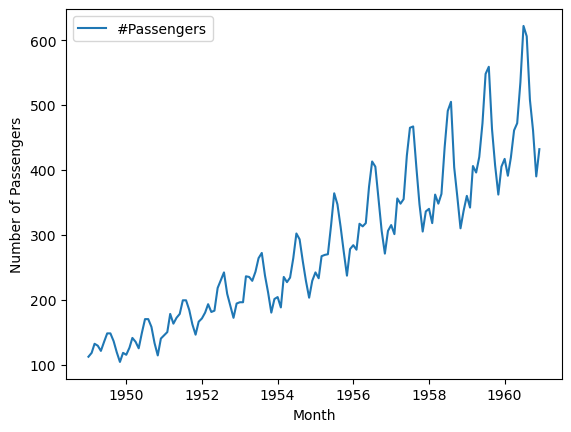

In [4]:
# Plot the data
sns.lineplot(df)
plt.ylabel('Number of Passengers')
plt.show()


#### Stationarity (is the data change constant)

Dickey Fuller Test:

null-hypothesis: there is no stationarity

In [5]:
# 7-month mean and standard deviation
rolling_mean = df.rolling(7).mean()
rolling_std = df.rolling(7).std()


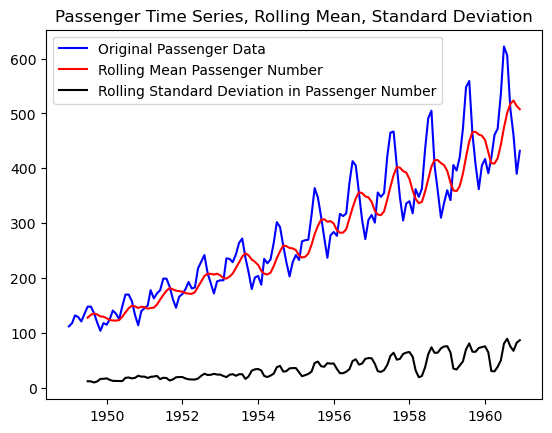

In [6]:
plt.plot(df, color='blue', label='Original Passenger Data')
plt.plot(rolling_mean, color='red', label='Rolling Mean Passenger Number')
plt.plot(rolling_std, color='black', label = 'Rolling Standard Deviation in Passenger Number')
plt.title('Passenger Time Series, Rolling Mean, Standard Deviation')
plt.legend(loc='best')
plt.show()


In [7]:
# Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller

adft = adfuller(df, autolag='AIC')

output_df = pd.DataFrame({'Values': [adft[0], adft[1], adft[2], adft[3], 
                                     adft[4]['1%'], adft[4]['5%'], adft[4]['10%']],
                          'Metric': ['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used', 
                                     'critical value (1%)', 'critical value (5%)', 'critical value (10%)']})
print(output_df)


       Values                       Metric
0    0.815369              Test Statistics
1    0.991880                      p-value
2   13.000000             No. of lags used
3  130.000000  Number of observations used
4   -3.481682          critical value (1%)
5   -2.884042          critical value (5%)
6   -2.578770         critical value (10%)


In [8]:
# The data is not stationary since the p-value is above 5% and the test statistic is greater than the critical value

#### Autocorrelation (is there a corrleation in the data with past values)

In [9]:
# One month lag
autocorrelation_lag1 = df['#Passengers'].autocorr(lag=1)
print('One Month Lag:', autocorrelation_lag1)

# Three month lag
autocorrelation_lag3 = df['#Passengers'].autocorr(lag=3)
print('Three Month Lag:', autocorrelation_lag3)

# Six month lag
autocorrelation_lag6 = df['#Passengers'].autocorr(lag=6)
print('Six Month Lag:', autocorrelation_lag6)

# Nine month lag
autocorrelation_lag9 = df['#Passengers'].autocorr(lag=9)
print('Nine Month Lag:', autocorrelation_lag9)


One Month Lag: 0.9601946480498523
Three Month Lag: 0.837394765081794
Six Month Lag: 0.7839187959206183
Nine Month Lag: 0.8278519011167601


#### Decomposition (to visualize trends)

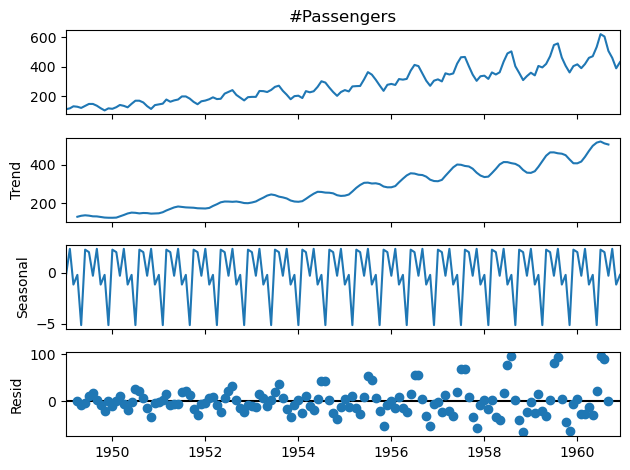

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df['#Passengers'], model='additive', period=7)
decompose.plot()
plt.show()


#### Forecasting

with ARIMA

In [11]:
# Training data
df['Date'] = df.index
train = df[df['Date'] < pd.to_datetime('1960-08', format='%Y-%m')]
train['train'] = train['#Passengers']

# Test data
del train['Date']
del train['#Passengers']
test = df[df['Date'] >= pd.to_datetime('1960-08', format='%Y-%m')]
del test['Date']
test['test'] = test['#Passengers']
del test['#Passengers']


C:\Users\Christoph\AppData\Local\Temp\ipykernel_12332\2810632095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['#Passengers']
C:\Users\Christoph\AppData\Local\Temp\ipykernel_12332\2810632095.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test['#Passengers']


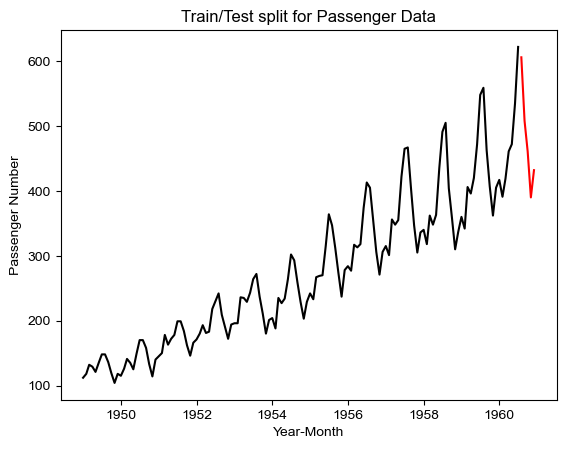

In [12]:
# Plot train and test data together
plt.plot(train, color = 'black')
plt.plot(test, color = 'red')
plt.title('Train/Test split for Passenger Data')
plt.ylabel('Passenger Number')
plt.xlabel('Year-Month')
sns.set()
plt.show()


In [13]:
# Train the model
from pmdarima.arima import auto_arima

model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1352.593, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1340.702, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1336.259, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1352.415, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1329.986, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1335.098, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1336.923, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1329.407, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1335.407, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1339.796, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1325.560, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1336.3

ARIMA(order=(4, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [14]:
# Forecast
forecast = model.predict(n_periods = len(test))
forecast = pd.DataFrame(forecast, index = test.index, columns=['Prediction'])


In [15]:
# Calculate RMSE
rms = sqrt(mean_squared_error(test,forecast))
print('RMSE:', rms)


RMSE: 61.36883664500577


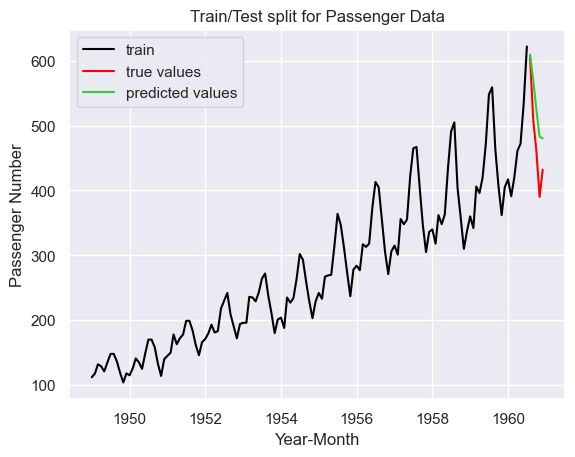

In [17]:
# Plot the results
plt.plot(train, color = 'black', label='train')
plt.plot(test, color = 'red', label='true values')
plt.plot(forecast, color= 'limegreen', label='predicted values')
plt.title('Train/Test split for Passenger Data')
plt.ylabel('Passenger Number')
plt.xlabel('Year-Month')
plt.legend()
sns.set()
plt.show()
